In [2]:
# Import necessary libraries for building and training the model
import torch  # PyTorch library for tensor operations and deep learning
import torch.nn as nn  # Submodule for defining neural network layers
import torch.optim as optim  # Submodule for optimization algorithms
import numpy as np  # NumPy library for numerical operations
# Import library for plotting and visualizing data
import matplotlib.pyplot as plt  # Used for creating plots

# Uncomment the following lines to set a random seed for reproducibility
torch.manual_seed(42)  # Sets the seed for PyTorch random number generation
#import numpy as np  # NumPy library for numerical operations
np.random.seed(42)  # Sets the seed for NumPy random number generation

# Create synthetic data for binary classification
# Generate 500 instances of negative class data with random values
X1 = torch.randn(500, 250, 100)  # Shape: [500 instances, 250 time steps, 100 features]
# Generate 500 instances of positive class data with random values shifted by 1.5
X2 = torch.randn(500, 250, 100) + 1.5  # Shape: [500 instances, 250 time steps, 100 features]
# Combine both classes into a single dataset
X = torch.cat([X1, X2], dim=0)  # Concatenate along the instance dimension (0)
# Create labels for the negative class (0)
Y1 = torch.zeros(500, 1)  # Shape: [500 instances, 1 label]
# Create labels for the positive class (1)
Y2 = torch.ones(500, 1)  # Shape: [500 instances, 1 label]
# Combine both labels into a single label tensor
Y = torch.cat([Y1, Y2], dim=0)  # Concatenate along the instance dimension (0)

# Print the shape of the input data tensor
print(X.size())  # Expected output: [1000 instances, 250 time steps, 100 features]
# Print the shape of the label tensor
print(Y.size())  # Expected output: [1000 instances, 1 label]

torch.Size([1000, 250, 100])
torch.Size([1000, 1])


In [3]:
# Define the neural network model
class Net(nn.Module):  # Inherit from PyTorch's base class for neural networks

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
        super().__init__()  # Initialize the base class
        # Store the feature representation type (mean or last state)
        self.feat_representation = feat_representation
        # Store whether the LSTM is bidirectional
        self.bidirectional = bidirectional
        # Define a fully connected layer to process input features
        self.fc1 = nn.Linear(feat_size, feat_size)  # Input and output dimensions are equal to feature size
        # Define a ReLU activation function
        self.relu = nn.ReLU()  # Applies the ReLU non-linearity
        # Define a dropout layer to prevent overfitting
        self.dout = nn.Dropout(dropout)  # Dropout probability is specified by the dropout parameter
        # Define an LSTM layer for sequential data processing
        self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True, bidirectional=bidirectional)  # Batch-first format ensures input shape is [batch, time, features]
        # Calculate the encoding size based on whether the LSTM is bidirectional
        encoding_size = hidden_size * 2 if bidirectional else hidden_size
        # Define another fully connected layer to process LSTM outputs
        self.fc2 = nn.Linear(encoding_size, hidden_size)  # Maps encoding size to hidden size
        # Define the output layer for binary classification
        self.out = nn.Linear(hidden_size, num_labels)  # Maps hidden size to the number of labels
        # Define a sigmoid activation function for output probabilities
        self.out_act = nn.Sigmoid()  # Converts logits to probabilities

    def forward(self, x):
        # Forward pass through the network
        # Input shape: [batch, time, features]
        h1 = self.fc1(x)  # Apply the first fully connected layer
        h1 = self.relu(h1)  # Apply ReLU activation
        # Pass the processed features through the LSTM layer
        outputs, (final, _) = self.lstm(h1)  # Outputs hidden states and final state from the RNN

        if self.feat_representation == 'mean':
            # Use the mean of hidden states as the feature representation
            outputs = self.dout(outputs)  # Apply dropout to hidden states
            h = self.relu(self.fc2(outputs))  # Process hidden states with a fully connected layer and ReLU
            h = h.mean(dim=1)  # Take the mean across the time dimension
        elif self.feat_representation == 'last_state':
            # Use the last hidden state as the feature representation
            if self.bidirectional:
                # Concatenate forward and backward states for bidirectional LSTM
                h_T_fwd = final[0]  # Forward state
                h_T_bwd = final[1]  # Backward state
                h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)  # Concatenate along the feature dimension
            else:
                # Use the last state for unidirectional LSTM
                h = final[-1]
            h = self.relu(self.fc2(h))  # Process the last state with a fully connected layer and ReLU
            h = self.dout(h)  # Apply dropout
        # Pass the feature representation through the output layer
        logits = self.out(h)  # Compute logits
        probs = self.out_act(logits)  # Convert logits to probabilities
        return logits, probs  # Return both logits and probabilities

# Instantiate the model
model = Net()  # Use default parameters
# Check for available device (e.g., MPS for Apple Silicon)
device = torch.device("mps")  # Specify the device
model = model.to(device)  # Move the model to the specified device
# Print the model architecture
print(model)  # Displays the layers and parameters of the model
# Define the Adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)  # Optimizer with learning rate of 0.001
# Define the binary cross-entropy loss function with logits
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid activation and binary cross-entropy

Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


/var/folders/b0/z48bvg0x3xj1q1ftpd_w4mb00000gn/T/ipykernel_82706/3911996130.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  loss_batch.append(loss.item())  # Save the loss value


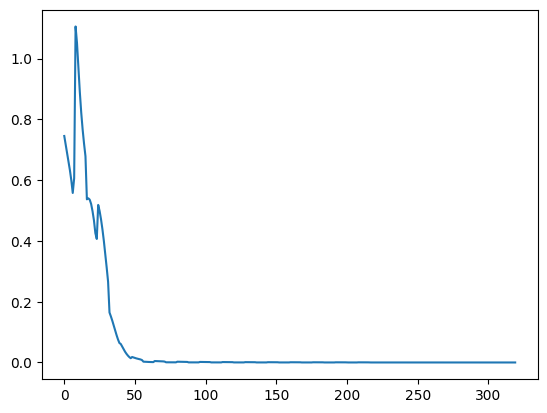

In [4]:
# Define hyperparameters for training
e_losses = []  # List to store epoch losses
num_epochs = 20  # Number of training epochs
batch_size = 64  # Number of instances per batch

# Training loop
for e in range(num_epochs):  # Iterate over epochs
    model.train()  # Set the model to training mode
    loss_batch = []  # List to store batch losses
    for beg_i in range(0, X.size(0), batch_size):  # Iterate over batches
        # Extract a batch of input data
        x_batch = X[beg_i:beg_i + batch_size, :]  # Select instances for the current batch
        y_batch = Y[beg_i:beg_i + batch_size, :]  # Select labels for the current batch
        x_batch = x_batch.to(device)  # Move input data to the device
        y_batch = y_batch.to(device)  # Move labels to the device

        opt.zero_grad()  # Reset gradients to zero
        # Forward pass through the model
        y_logits, y_probs = model(x_batch)  # Compute logits and probabilities
        # Compute the loss for the batch
        loss = criterion(y_logits, y_batch)  # Binary cross-entropy loss
        loss_batch.append(loss.item())  # Save the loss value
        # Backward pass to compute gradients
        loss.backward()  # Compute gradients for all parameters
        # Update model parameters
        opt.step()  # Apply the optimizer step

    e_losses += loss_batch  # Append batch losses to epoch losses
# Plot the loss over epochs
plt.plot(e_losses)  # Visualize the training loss

In [5]:
# Make predictions with the trained model
x_t = torch.randn(1, 5000, 100)  # Generate a random test instance
x_t = x_t.to(device)  # Move the test instance to the device

model.eval()  # Set the model to evaluation mode
y_logit, y_prob = model(x_t)  # Compute logits and probabilities for the test instance
print(y_prob.item())  # Print the predicted probability
x_1_t = torch.randn(1, 5000, 100) + 1.5  # Generate another test instance with shifted values
x_1_t = x_1_t.to(device)  # Move the second test instance to the device
y1_logit, y1_prob = model(x_1_t)  # Compute logits and probabilities for the second test instance
print(y1_prob.item())  # Print the predicted probability for the second instance

0.0002206692297477275
0.9999586343765259


# TODO

Make a new section for each new model NetLast(), NetBiLSTM(), NetDropout()....

- Try different feature representations: last state and bidirectional LSTM
- Try different feature sizes, and dropout [0.1, 0.5, 0.8]
- Try different non-linearities: sigmoid, tanh
- Use a GRU instead of LSTM: [GRU PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
- What if we predict a sequence instead of classification?
```python
# [N, T, F] number of instances, time, features
X1 = torch.randn(1000, 48, 50)
X2 = torch.randn(1000, 48, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
mask = torch.cuda.FloatTensor(2000, 48, 1).uniform_() > 0.8
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
# [B, 1]
Y_mean = torch.cat([Y1, Y2], dim=0)
# [B, T, 1]
Y_seq = Y_mean.unsqueeze(1).repeat(1, 48, 1)
# [N, F] instances, time, features
print(X.size())
# [N, 1] instances, label [0,1]
print(Y_seq.size())
# print(Y_mean.size())
print(mask.size())
# In model
def forward(self, x):
    #...
    # [B, T, H]
    # h_mean = h_time.mean(1)
    # [B, T, H] logits is a seq
    # logits_mean = self.out_mean(h_mean)
    return logits_seq
# Criterion
criterion = nn.BCEWithLogitsLoss(reduction='none')
# [B, 1] mean (0)
# Loss
# [B, T, 1]
loss_seq = loss_seq * x_mask
loss_seq = loss_seq.sum(1)
loss_seq = loss_seq.mean(0)
```
- Change BCE logits to probs https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html